<a href="https://colab.research.google.com/github/laplezeda/agents/blob/main/Vision_Agent_using_Langgraph_Part_2_(Email_sending_tool).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agents in LangGraph

In this notebook, **we're going to build a simple agent using using LangGraph**.


In [ ]:
%pip install -q -U langchain_openai langchain_core langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.1 MB/s eta 0:00:00


In [ ]:
%pip install -q langfuse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.4/294.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install sendgrid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.1/102.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 12.4 MB/s eta 0:00:00


In [ ]:
import os
os.environ["SENDGRID_API_KEY"] = ""
os.environ["OPENAI_API_KEY"] = ""
# Get keys for your project from the project settings page: https://cloud.langfuse.com

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUS"] = ""
os.environ["LANGFUSE_SECRET_KEY"] = ""
#os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"  # 🇪🇺 EU region
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # 🇺🇸 US region


In [ ]:
from langfuse.langchain import CallbackHandler

# Initialize Langfuse CallbackHandler for LangGraph/Langchain (tracing)
langfuse_handler = CallbackHandler()

In [ ]:
import base64
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

vision_llm = ChatOpenAI(model="gpt-4o")


def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""


llm = ChatOpenAI(model="gpt-4o")


def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b


In [ ]:
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail

def send_html_email(html_body: str,
                    sender: str = "rajatdandekar@vizuara.com",
                    receiver: str = "Raj.dandekar8@gmail.com",
                    subject: str = "Dinner shopping list") -> str:
    """
    Send an HTML e-mail via SendGrid.

    Args:
        html_body:  Valid HTML to be used as the message body.
        sender:     Verified 'from' address in your SendGrid account.
        receiver:   Destination address (must be verified in free tier).
        subject:    Subject line.

    Returns:
        Status string for the agent to read back.
    """
    message = Mail(
        from_email=sender,
        to_emails=receiver,
        subject=subject,
        html_content=html_body
    )
    try:
        sg = SendGridAPIClient(os.environ["SENDGRID_API_KEY"])
        resp = sg.send(message)
        return f"✉️ SendGrid response {resp.status_code}"
    except Exception as e:
        return f"❌ SendGrid error: {e}"


In [ ]:
tools = [divide, extract_text, send_html_email]

llm_with_tools = llm.bind_tools(
    tools,
    parallel_tool_calls=False,
    #force_tool=True
)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [ ]:
from typing import TypedDict, Annotated, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The input document
    input_file: Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


def assistant(state: AgentState):
    # System message
    textual_description_of_tool = """
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b

    send_html_email(html_body: str,
                sender: str,
                receiver: str,
                subject: str) -> str:
    Send an HTML e-mail via SendGrid and return a status string.
"""
    image = state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computations without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")

    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])], "input_file": state["input_file"]}

We define a `tools` node with our list of tools.

The `assistant` node is just our model with bound tools.

We create a graph with `assistant` and `tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `tools` based on  whether the `assistant` calls a tool.

Now, we add one new step:

We connect the `tools` node *back* to the `assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

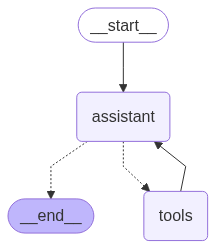

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages, "input_file": None}, config={"callbacks": [langfuse_handler]})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_tnZFnASNHJKN5VLW1tTlZjg2)
 Call ID: call_tnZFnASNHJKN5VLW1tTlZjg2
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

The result of dividing 6790 by 5 is 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner left in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [ ]:
# Create initial messages
messages = [HumanMessage(content="According to the note provided by MR Wayne in the provided images, what's the list of items I should buy for the dinner menu?")]

# Invoke react_graph with Langfuse callback integrated
messages = react_graph.invoke(
    {
        "messages": messages,
        "input_file": "Batman_training_and_meals.png"
    },
    config={"callbacks": [langfuse_handler]}
)

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the note provided by MR Wayne in the provided images, what's the list of items I should buy for the dinner menu?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_KxaTuTjFloNJGJO80XbtxRDV)
 Call ID: call_KxaTuTjFloNJGJO80XbtxRDV
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
   30 minute jog
   30 minute meditation

EVENING
   clean and jerk lifts—3 reps/8 sets. 262 lbs.
   5 sets metabolic conditioning:
      21 kettlebell swings
      12 pull-ups
      30 minutes flexibility
      30 minutes sparring

MONDAY 2/21
MORNING
   30 minute jog
   30 minutes traditional kata (focus on Japanese forms)

EVENING
   5 sets 20 foot rope climb
   30 minutes gymnastics (wor

In [ ]:
# Create initial messages
messages = [HumanMessage(content="According to the note provided by MR Wayne in the provided images, what's the list of items I should buy for the dinner menu? Count the number of items and divide them by 50. Give resulting answer. Don't stop until you have integer answer")]

# Invoke react_graph with Langfuse callback integrated
messages = react_graph.invoke(
    {
        "messages": messages,
        "input_file": "Batman_training_and_meals.png"
    },
    config={"callbacks": [langfuse_handler]}
)

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According to the note provided by MR Wayne in the provided images, what's the list of items I should buy for the dinner menu? Count the number of items and divide them by 50. Give resulting answer. Don't stop until you have integer answer
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_a6ZsyWKmcitOfU7ehMIoCU3A)
 Call ID: call_a6ZsyWKmcitOfU7ehMIoCU3A
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

```
TRAINING SCHEDULE
For the week of 2/20-2/26

SUNDAY 2/20
MORNING
30 minute jog
30 minute meditation

EVENING 
clean and jerk lifts—3 reps/8 sets. 262 lbs.
5 sets metabolic conditioning:
    12 pull-ups
    12 kettlebell swings
    24 push-ups
30 minutes flexibility 
30 minutes sparring

MONDAY 2/21
MORNING
30 minute jog
30 minutes tradition

In [ ]:
# Create initial messages
messages = [HumanMessage(content="According to the note provided by MR Wayne in the provided images, what's the list of items I should buy for the dinner menu? Then send an email to the recipient email with the list of items")]

# Invoke react_graph with Langfuse callback integrated
messages = react_graph.invoke(
    {
        "messages": messages,
        "input_file": "Batman_training_and_meals.png"
    },
    config={"callbacks": [langfuse_handler]}
)